In [1]:
import sys
sys.path.insert(1, '../../scripts/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import datetime
from midoss_utils import *
import yaml
import time

In [2]:
# graphics style
plt.style.use(r"../presentations/MEOPAR2022/meopar2022_matplotlibrc.template")

In [3]:
color_dict = {"MEvaporated": "darkolivegreen",
              "MDispersed": "darkblue", 
              "MDissolved": "royalblue", 
              "MBio": "skyblue",
              "MFloating": "saddlebrown", 
             "MBeached": "chocolate", 
             "MInitial": "grey",
             "MTotal":"magenta"}
oil_dict = {"akns":"ANS",
            "all":"all",
           "bunker":"Bunker-C",
           "diesel":"Diesel",
           "dilbit":"Dilbit",
           "gas":"Diesel",
           "jet":"Diesel",
           "other":"Bunker-C"}
cols_plot = ["MEvaporated", "MDispersed",  "MDissolved", "MBio", "MFloating", "MBeached", "MInitial","MTotal"]
oil_types = ["dilbit", "akns", "diesel","bunkerc"]
# Select True to re-run cataloguing code and False to open "input_file" instead
catalogue_flag = False

In [4]:
# load yaml file with filepaths for .sro files
file_paths = '/scratch/rmueller/MIDOSS/Results/MOHID_massbalance_13022022_18:10:19.yaml'
output_dir =Path('/scratch/rmueller/MIDOSS/Results')
input_file = output_dir / 'SOILED_massbalance_byoil_15022022_17:45:00.yaml'

In [5]:
%%time
# For debugging purposes: Create count dictionary of files opened by oil type
count = {}
for oil in ["Bunker-C", "Diesel", "Dilbit", "ANS",'all']:
    count[oil]=0
# open yaml file that contains dictionary of file paths created in 
# create_SOILED_sro_runlist.ipynb and catalogue data. 
if catalogue_flag:
    with open(file_paths) as file:
        sro_files = yaml.safe_load(file)
    # Initialize dictionary for output 
    output = {}
    variables = ['MEvaporated', 'MDispersed', 'MDissolved',
                 'MBio','MassOil','VolOilBeached',
                 'Density','VWaterContent','MWaterContent']
    # initialize dictionary
    for oil in [*sro_files]:
        output[oil_dict[oil]]={}
        output[oil_dict[oil]]['month'] = []
        output[oil_dict[oil]]['days_since_spill']=[]
        output[oil_dict[oil]]['MBeached']=[]
        for var in variables:
                output[oil_dict[oil]][var]=[]
    # loop through oils and catalogue data
    for oil in [*sro_files]:
        print(oil)  
        # load mass balance from .sro files for each oil type
        for fnum,file in enumerate(sro_files[oil]):               
            sro_file = sro_files[oil][fnum]
             #~~~ Load data and tidy it up ~~~
            data = pandas.read_csv(sro_file, sep="\s+", skiprows=4)
            # remove first entry of NaN values
            data = data.drop([0], axis=0)
            length = len(data)
            # Make sure there is data in the file
            if length>4:
                # tidy up NaN and garbage entries at end of file
                data = data.drop([length-3, length-2, length-1, length], axis=0)
                data_last = data[-1:]
                # Count files to help debug
                count[oil_dict[oil]]+=1
                output[oil_dict[oil]]['month'].append(int(data_last["MM"].item()))
                output[oil_dict[oil]]['days_since_spill'].append(float(data_last["Seconds"])/86400)
                # Catalogue last value for each, selected variable
                for var in variables:
                    output[oil_dict[oil]][var].append(data_last[var].item())
                # calculate MBeached
                output[oil_dict[oil]]['MBeached'].append(
                    (data_last['VolOilBeached']*data_last['Density']/(1-data_last['VWaterContent'])*(1-data_last['MWaterContent'])).item())
            else:
                print(sro_file)
                continue
    for oil in [*sro_files]: 
        print(f"{oil}: {len(output[oil_dict[oil]]['MBeached'])}")
    # rename MassOil for more transparancy of meaning
    # This doesn't work....hmmm....
    # for oil in [*output]:
    #     output[oil] = output[oil].rename(columns={"MassOil":"MFloating"})            
    # write filenames to .yaml with timestamp in filename
    now = datetime.datetime.now()
    dt_string = now.strftime("%d%m%Y_%H:%M:%S")
    out_f = output_dir+f'/SOILED_massbalance_byoil_{dt_string}.yaml'
    with open(out_f, 'w') as output_yaml:
        documents = yaml.safe_dump(output, output_yaml)
else:
    with open(input_file, 'r') as input_yaml:
        sro = yaml.safe_load(input_yaml)

CPU times: user 6.4 s, sys: 88.8 ms, total: 6.48 s
Wall time: 7.21 s


In [6]:
with open(input_file) as file:
    sro = yaml.safe_load(file)

In [7]:
mass_elements = ['MEvaporated', 'MDispersed','MDissolved', 'MBio', 'MassOil', 'MBeached']
   
MDispersed = numpy.asarray(sro['all']['MDispersed'])
MEvaporated = numpy.asarray(sro['all']['MEvaporated'])
MDissolved = numpy.asarray(sro['all']['MDissolved'])
MBio = numpy.asarray(sro['all']['MBio'])
MSurface = numpy.asarray(sro['all']['MassOil']) #surface oil
MBeached = numpy.asarray(sro['all']['MBeached'])
Mtotal = MEvaporated + MDispersed + MDissolved + MBio + MSurface + MBeached

In [8]:
MIDOSScolors={
    'ANS': 'purple',
    'Bunker-C':'teal',
    'Dilbit':'magenta',
    'Diesel':'cornflowerblue',
}

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


*** Days since spill at last time step ***
min, max, mean, median
1214
0.1 7.0 5.4 7.0  [Bunker-C]
2030
0.1 7.0 4.6 7.0  [Diesel]
1
1.2 1.2 1.2 1.2  [Dilbit]
30
1.5 7.0 6.7 7.0  [ANS]


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


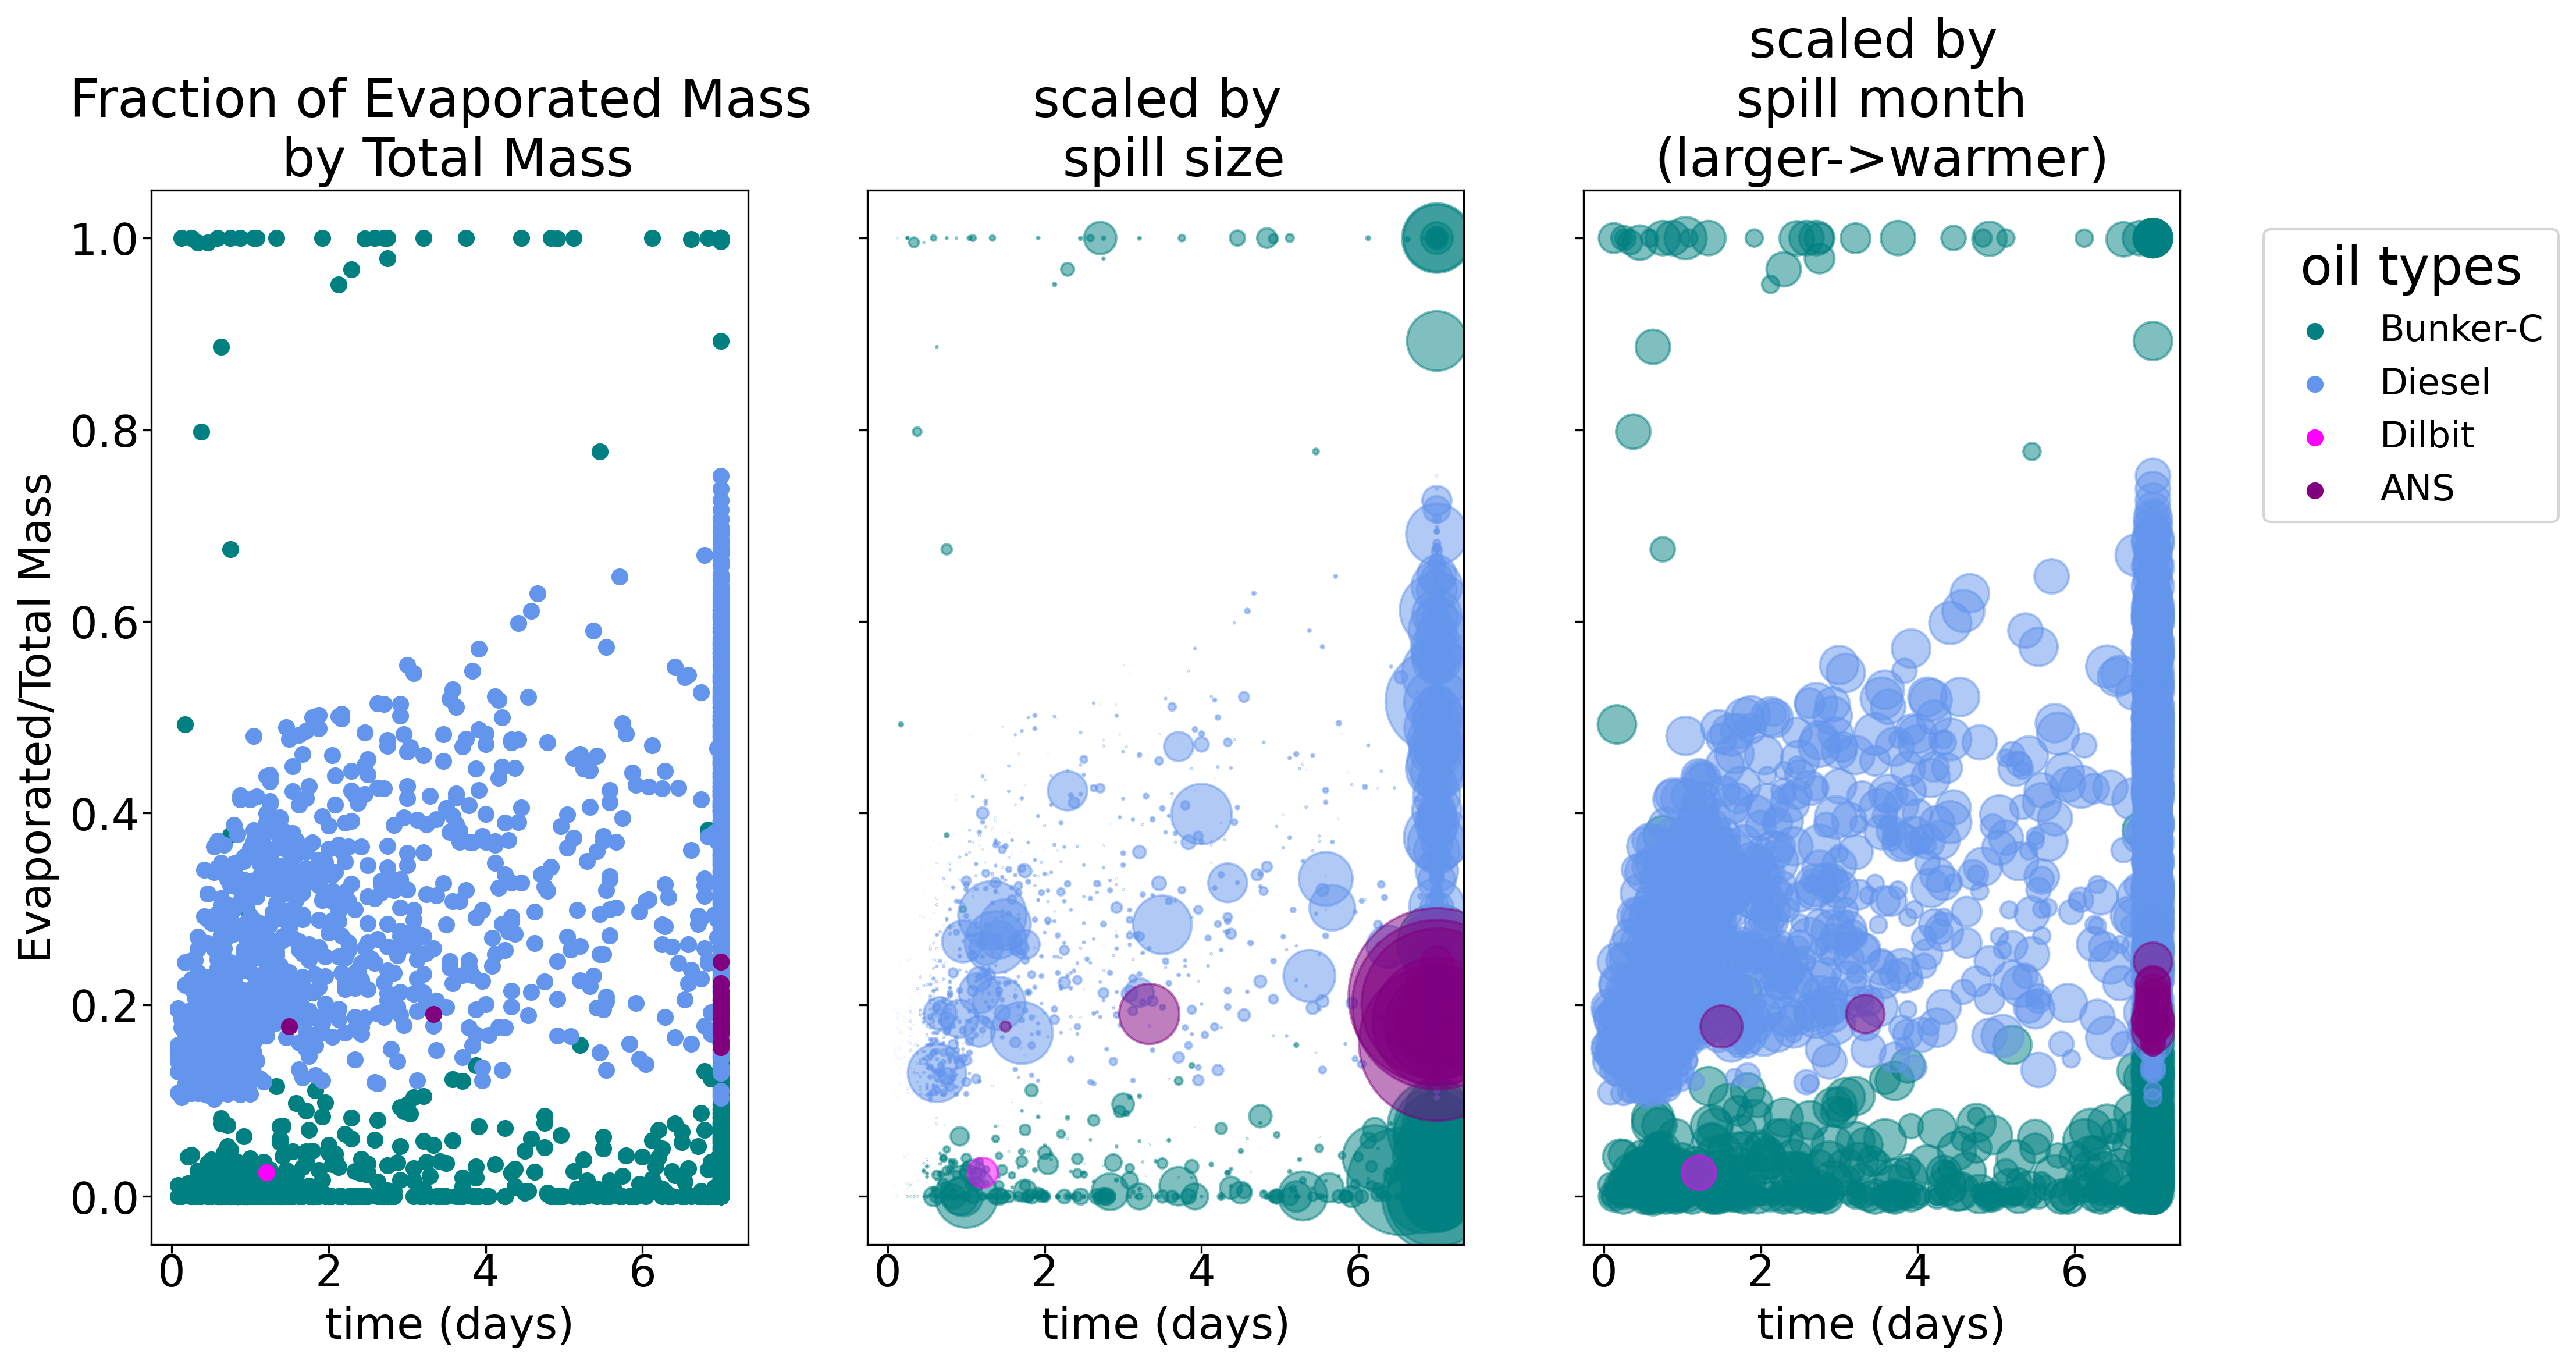

In [9]:
oils=['Bunker-C', 'Diesel', 'Dilbit','ANS']

mean = {}
mean['MDispersed'] = []
mean['MEvaporated'] = []
mean['MDissolved'] = []
mean['MBio'] = []
mean['MSurface'] = []
mean['MBeached'] = []

median = {}
median['MDispersed'] = []
median['MEvaporated'] = []
median['MDissolved'] = []
median['MBio'] = []
median['MSurface'] = []
median['MBeached'] = []

# fraction of spill
spill_fraction = {}
spill_fraction['MDispersed'] = {}
spill_fraction['MEvaporated'] = {}
spill_fraction['MDissolved'] = {}
spill_fraction['MBio'] = {}
spill_fraction['MSurface'] = {}
spill_fraction['MBeached'] = {}

fig, ax = plt.subplots(1,3,figsize=(15,8))
print('*** Days since spill at last time step ***')
print('min, max, mean, median')
mass_arr = np.array([])
for oil in oils:
    print(len(sro[oil]['MDispersed']))
    
    MDispersed = numpy.asarray(sro[oil]['MDispersed'])
    MEvaporated = numpy.asarray(sro[oil]['MEvaporated'])
    MDissolved = numpy.asarray(sro[oil]['MDissolved'])
    MBio = numpy.asarray(sro[oil]['MBio'])
    MSurface = numpy.asarray(sro[oil]['MassOil']) #surface oil
    MBeached = numpy.asarray(sro[oil]['MBeached'])
    Mtotal = MEvaporated + MDispersed + MDissolved + MBio + MSurface + MBeached
    # store month and mass information for scaling scatter plot markers
    month = numpy.asarray(sro[oil]['month'])
    mass_arr = np.concatenate((mass_arr, Mtotal))
    # calculate fraction of spill
    spill_fraction['MDispersed'][oil] = []
    spill_fraction['MEvaporated'][oil] = []
    spill_fraction['MDissolved'][oil] = []
    spill_fraction['MBio'][oil] = []
    spill_fraction['MSurface'][oil] = []
    spill_fraction['MBeached'][oil] = []
    # 
    spill_fraction['MDispersed'][oil] = MDispersed/Mtotal
    spill_fraction['MEvaporated'][oil] = MEvaporated/Mtotal
    spill_fraction['MDissolved'][oil] = MDissolved/Mtotal
    spill_fraction['MBio'][oil] = MBio/Mtotal
    spill_fraction['MSurface'][oil] = MSurface/Mtotal
    spill_fraction['MBeached'][oil] = MBeached/Mtotal
    # calculate mean
    mean['MDispersed'].append(numpy.mean(MDispersed))
    mean['MEvaporated'].append(numpy.mean(MEvaporated))
    mean['MDissolved'].append(numpy.mean(MDissolved))
    mean['MBio'].append(numpy.mean(MBio))
    mean['MSurface'].append(numpy.mean(MSurface))
    mean['MBeached'].append(numpy.mean(MBeached))
    # calculate median
    median['MDispersed'].append(numpy.median(MDispersed))
    median['MEvaporated'].append(numpy.median(MEvaporated))
    median['MDissolved'].append(numpy.median(MDissolved))
    median['MBio'].append(numpy.median(MBio))
    median['MSurface'].append(numpy.median(MSurface))
    median['MBeached'].append(numpy.median(MBeached))
    print(f"{numpy.min(sro[oil]['days_since_spill']):2.1f}",
          f"{numpy.max(sro[oil]['days_since_spill']):2.1f}",
          f"{numpy.mean(sro[oil]['days_since_spill']):2.1f}",
          f"{numpy.median(sro[oil]['days_since_spill']):2.1f}",
         f" [{oil}]")
    
    ax[0].scatter(sro[oil]['days_since_spill'],
                  MEvaporated/Mtotal, 
                  c=MIDOSScolors[oil], 
                  label=oil)
    ax[1].scatter(sro[oil]['days_since_spill'], 
                  MEvaporated/Mtotal, 
                  s=40*Mtotal/3e5, #scaled by ~mean
                  alpha=0.5,
                  c=MIDOSScolors[oil], 
                  label=oil)
    ax[2].scatter(sro[oil]['days_since_spill'], 
                  MEvaporated/Mtotal, 
                  s=300*(1-numpy.absolute((month-6)/6)),
                  alpha=0.5,
                  c=MIDOSScolors[oil], 
                  label=oil)
    
    
ax[0].legend(title='oil types',
         bbox_to_anchor=(3.51, 0.98), 
         loc='upper left')
ax[0].set_title('Fraction of Evaporated Mass \n by Total Mass')
ax[1].set_title('scaled by \n spill size')
ax[2].set_title('scaled by \n spill month \n(larger->warmer)')
ax[0].set_ylabel('Evaporated/Total Mass')
ax[0].set_xlabel('time (days)')
for ax_ind in [1,2]:
    ax[ax_ind].set_yticklabels([])
    ax[ax_ind].set_xlabel('time (days)')
plt.show()

### Graphic explanation:
From left to right, the above graphic shows: 
- (a) all spill's evaporation fraction from the last time-step, 
- (b) the same as (a) but with the evaporation fraction scaled by the mean spill mass of all spills
- (c) the same as (a) but with the evaporation fraction scaled by the month of the spill, where the largest size reflects June spill month and the smallest size reflects winter spill months (January and December)

**Take-away**: Evaporation fraction doesn't appear to be strongly influenced by spill size or spill month.  A plausible explanation is that evaporation is set by SST and these two metrics don't track SST (as well as region of spill might?).  I can't yet explain why some Bunker-C spills have such a large Evaporation fraction and why the evaporation fraction for Bunker-C appears to be bimodal.  I see this bimodal fate behavior as a curious result to dig into more. See `MDisolved` below for possible insight.  Do the negative `MDisolved` runs match the runs with high evaporation rate fractions? Do the runs that don't beach relfection the runs with negative dissolution and high evaporation? 

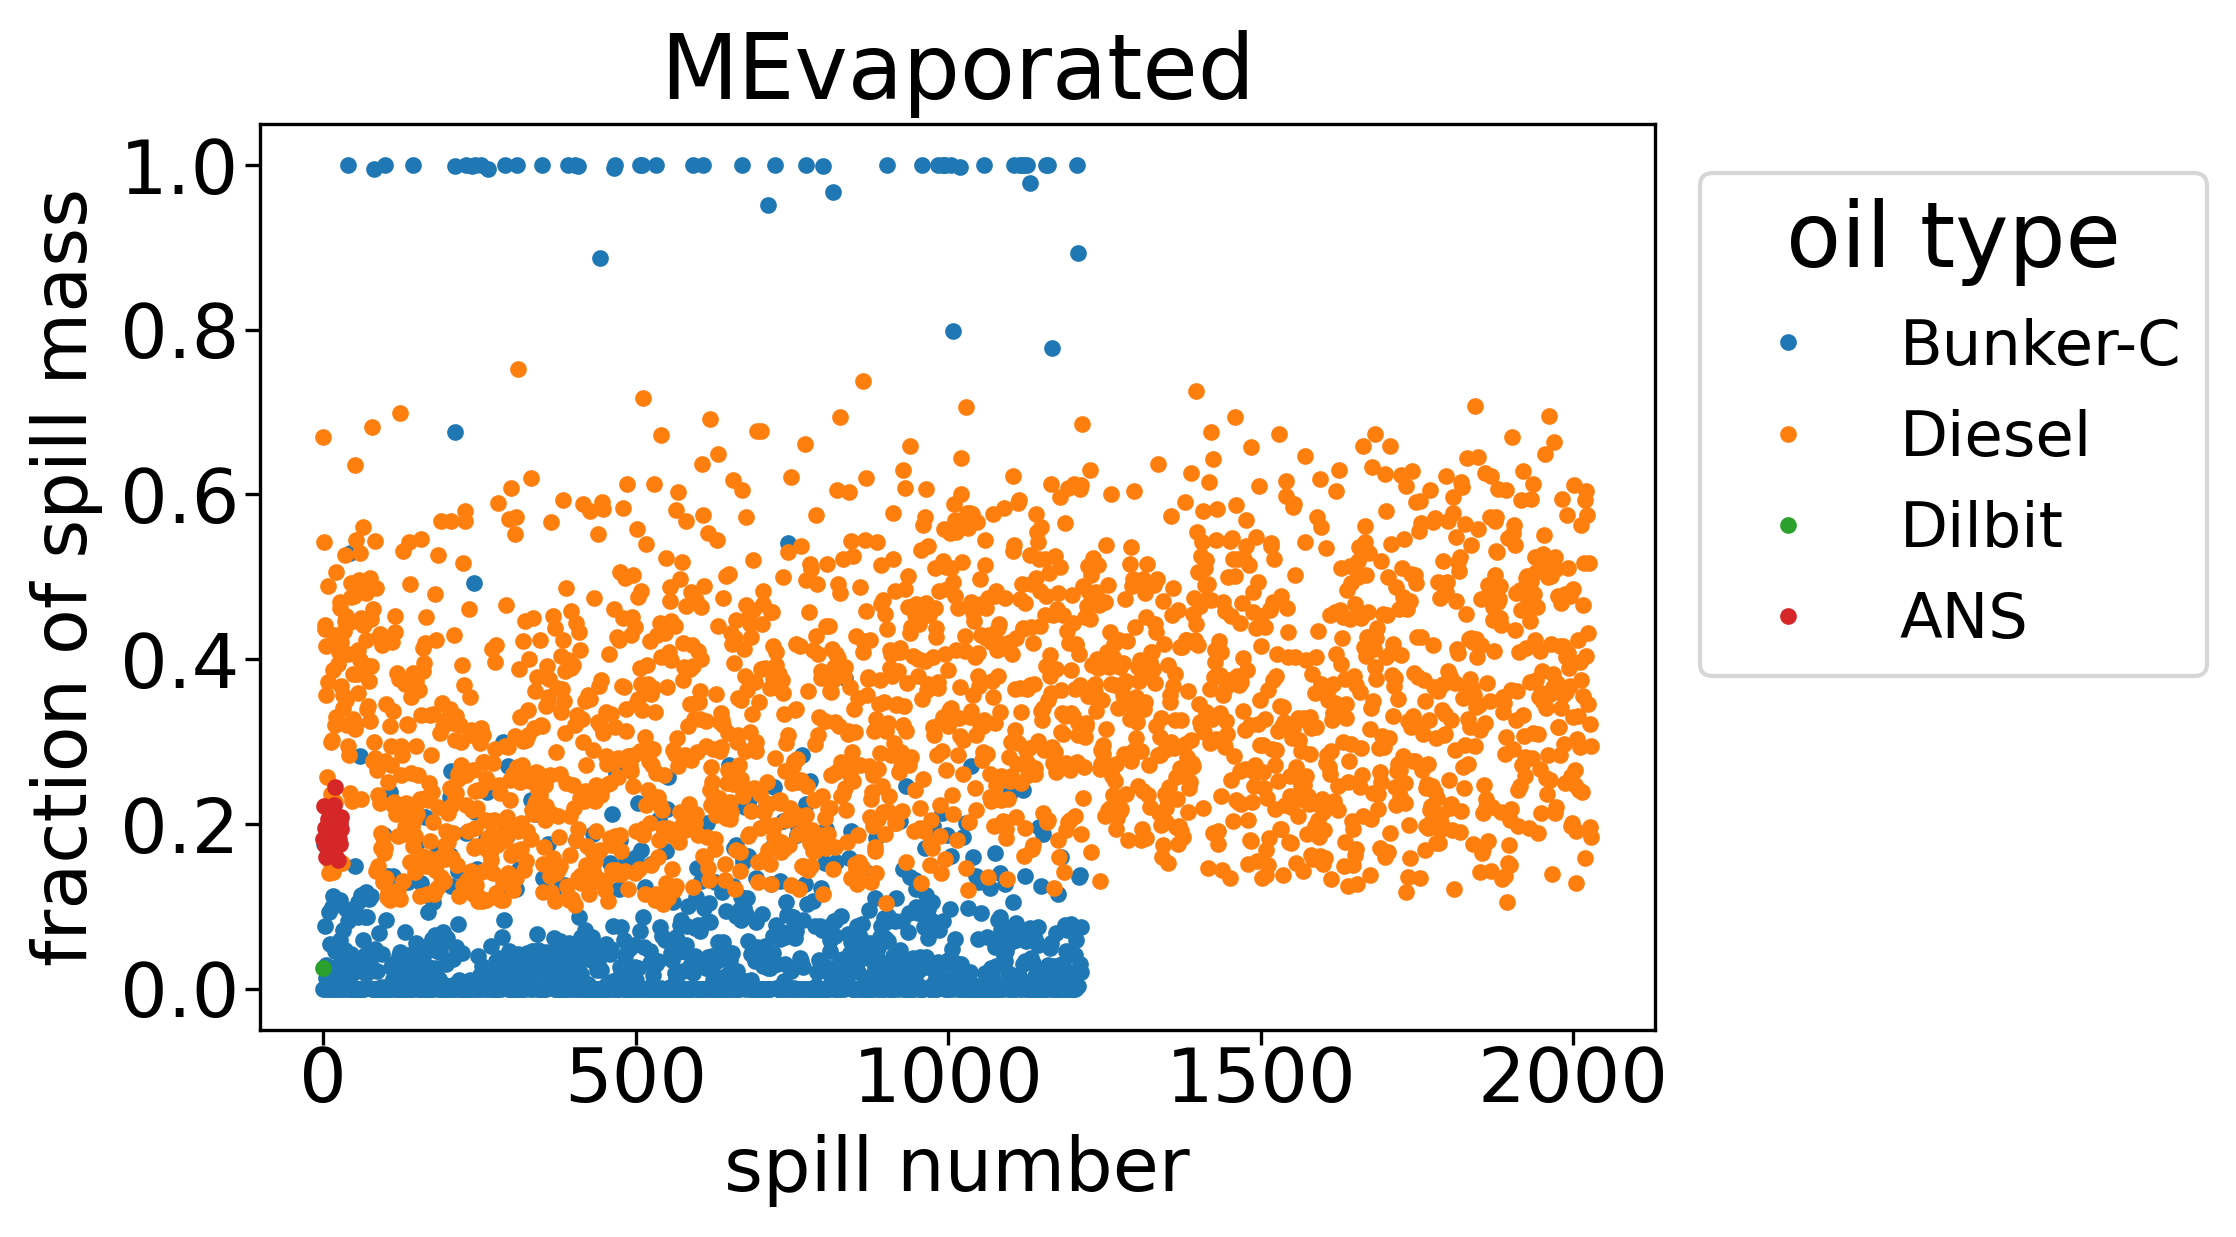

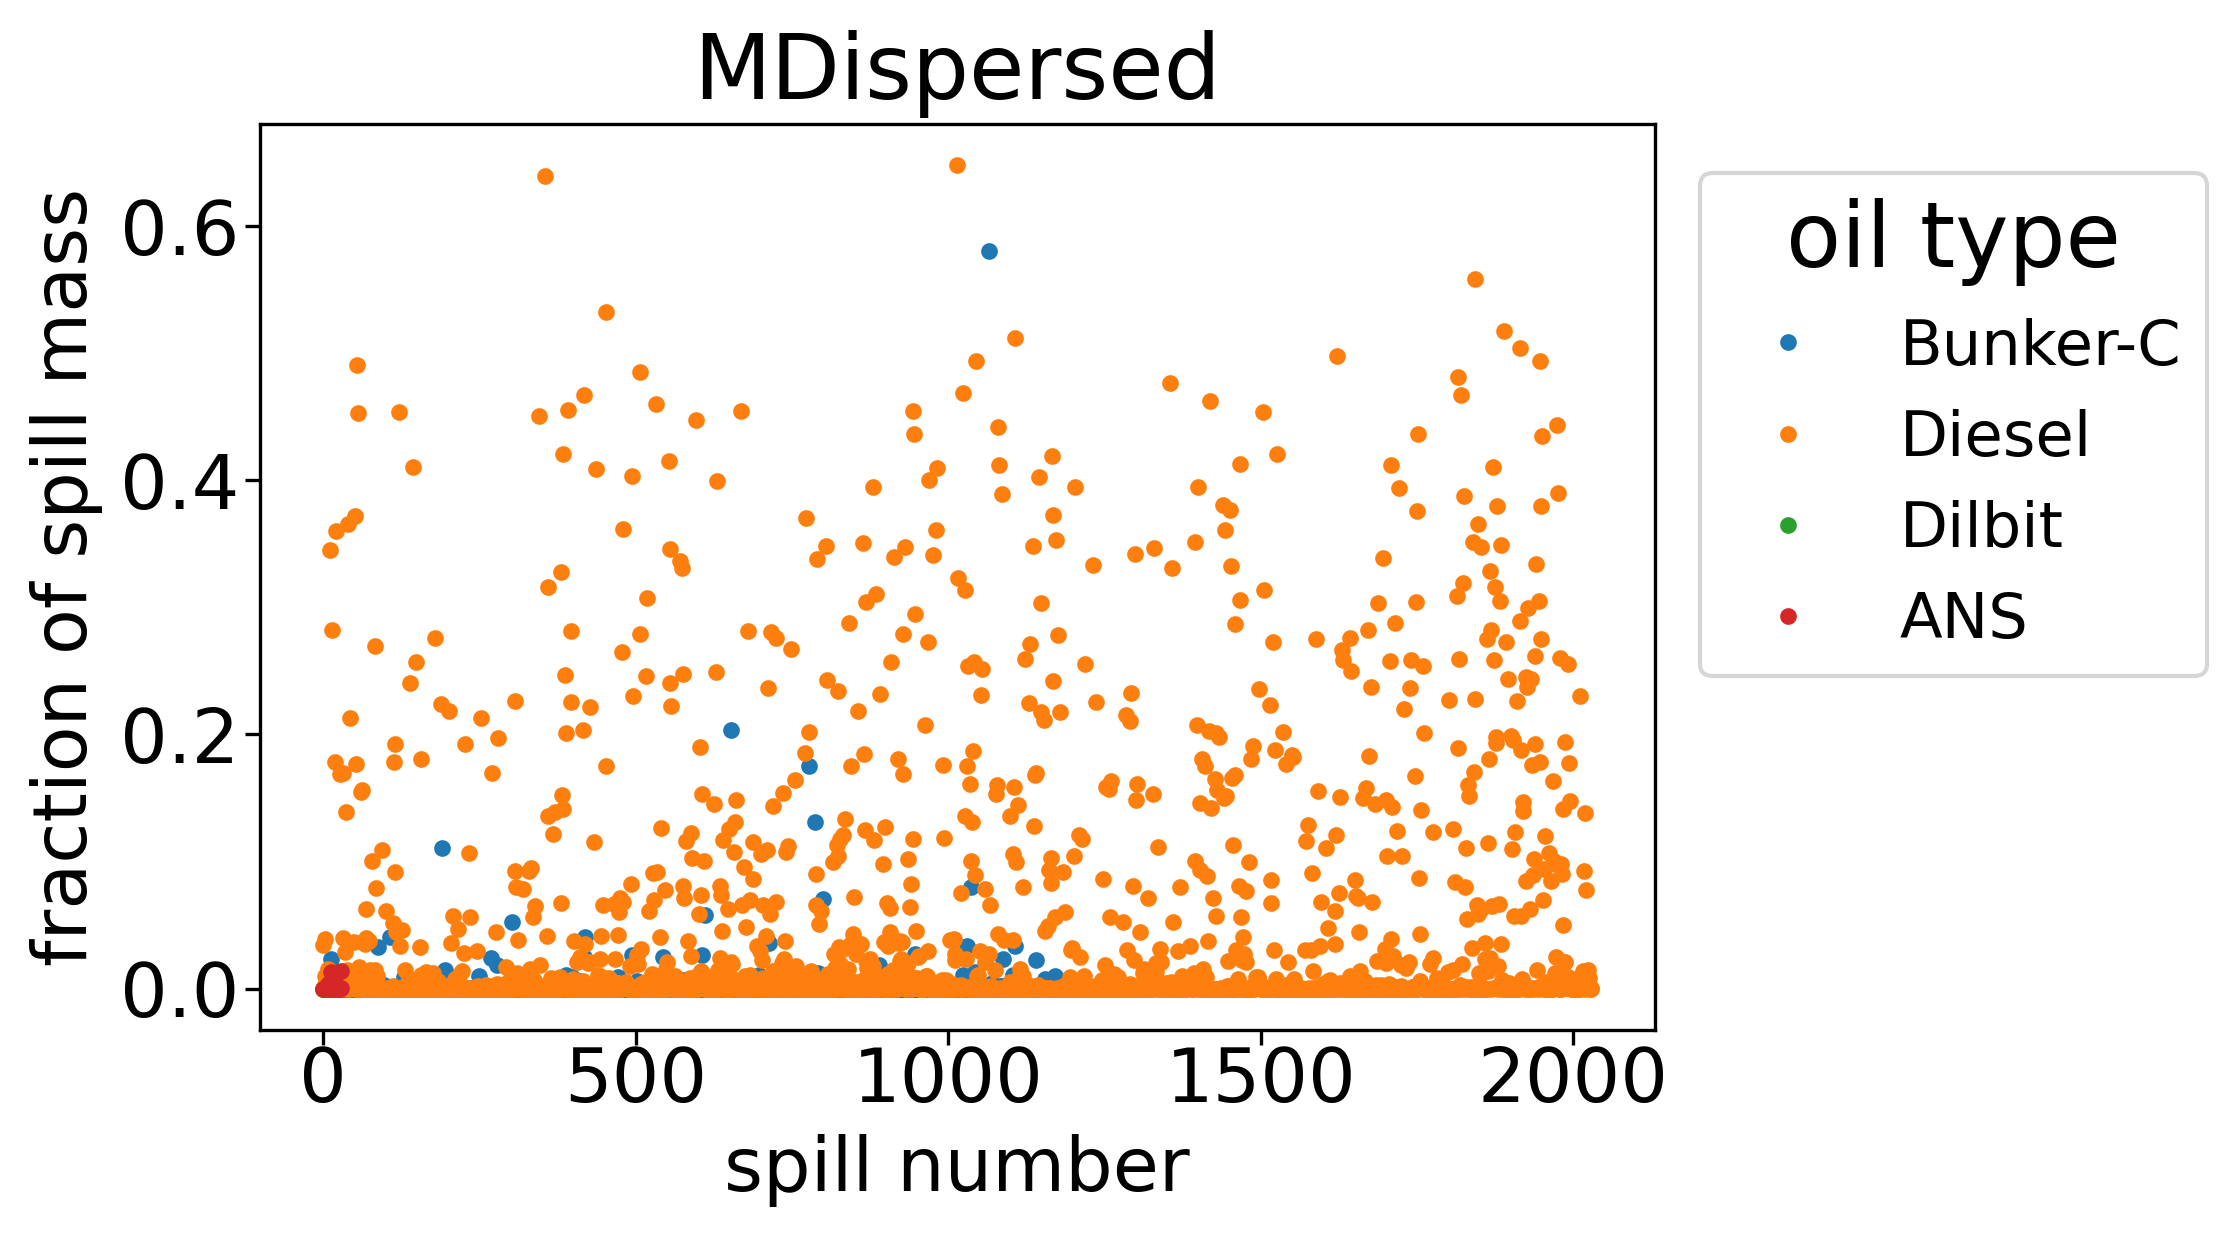

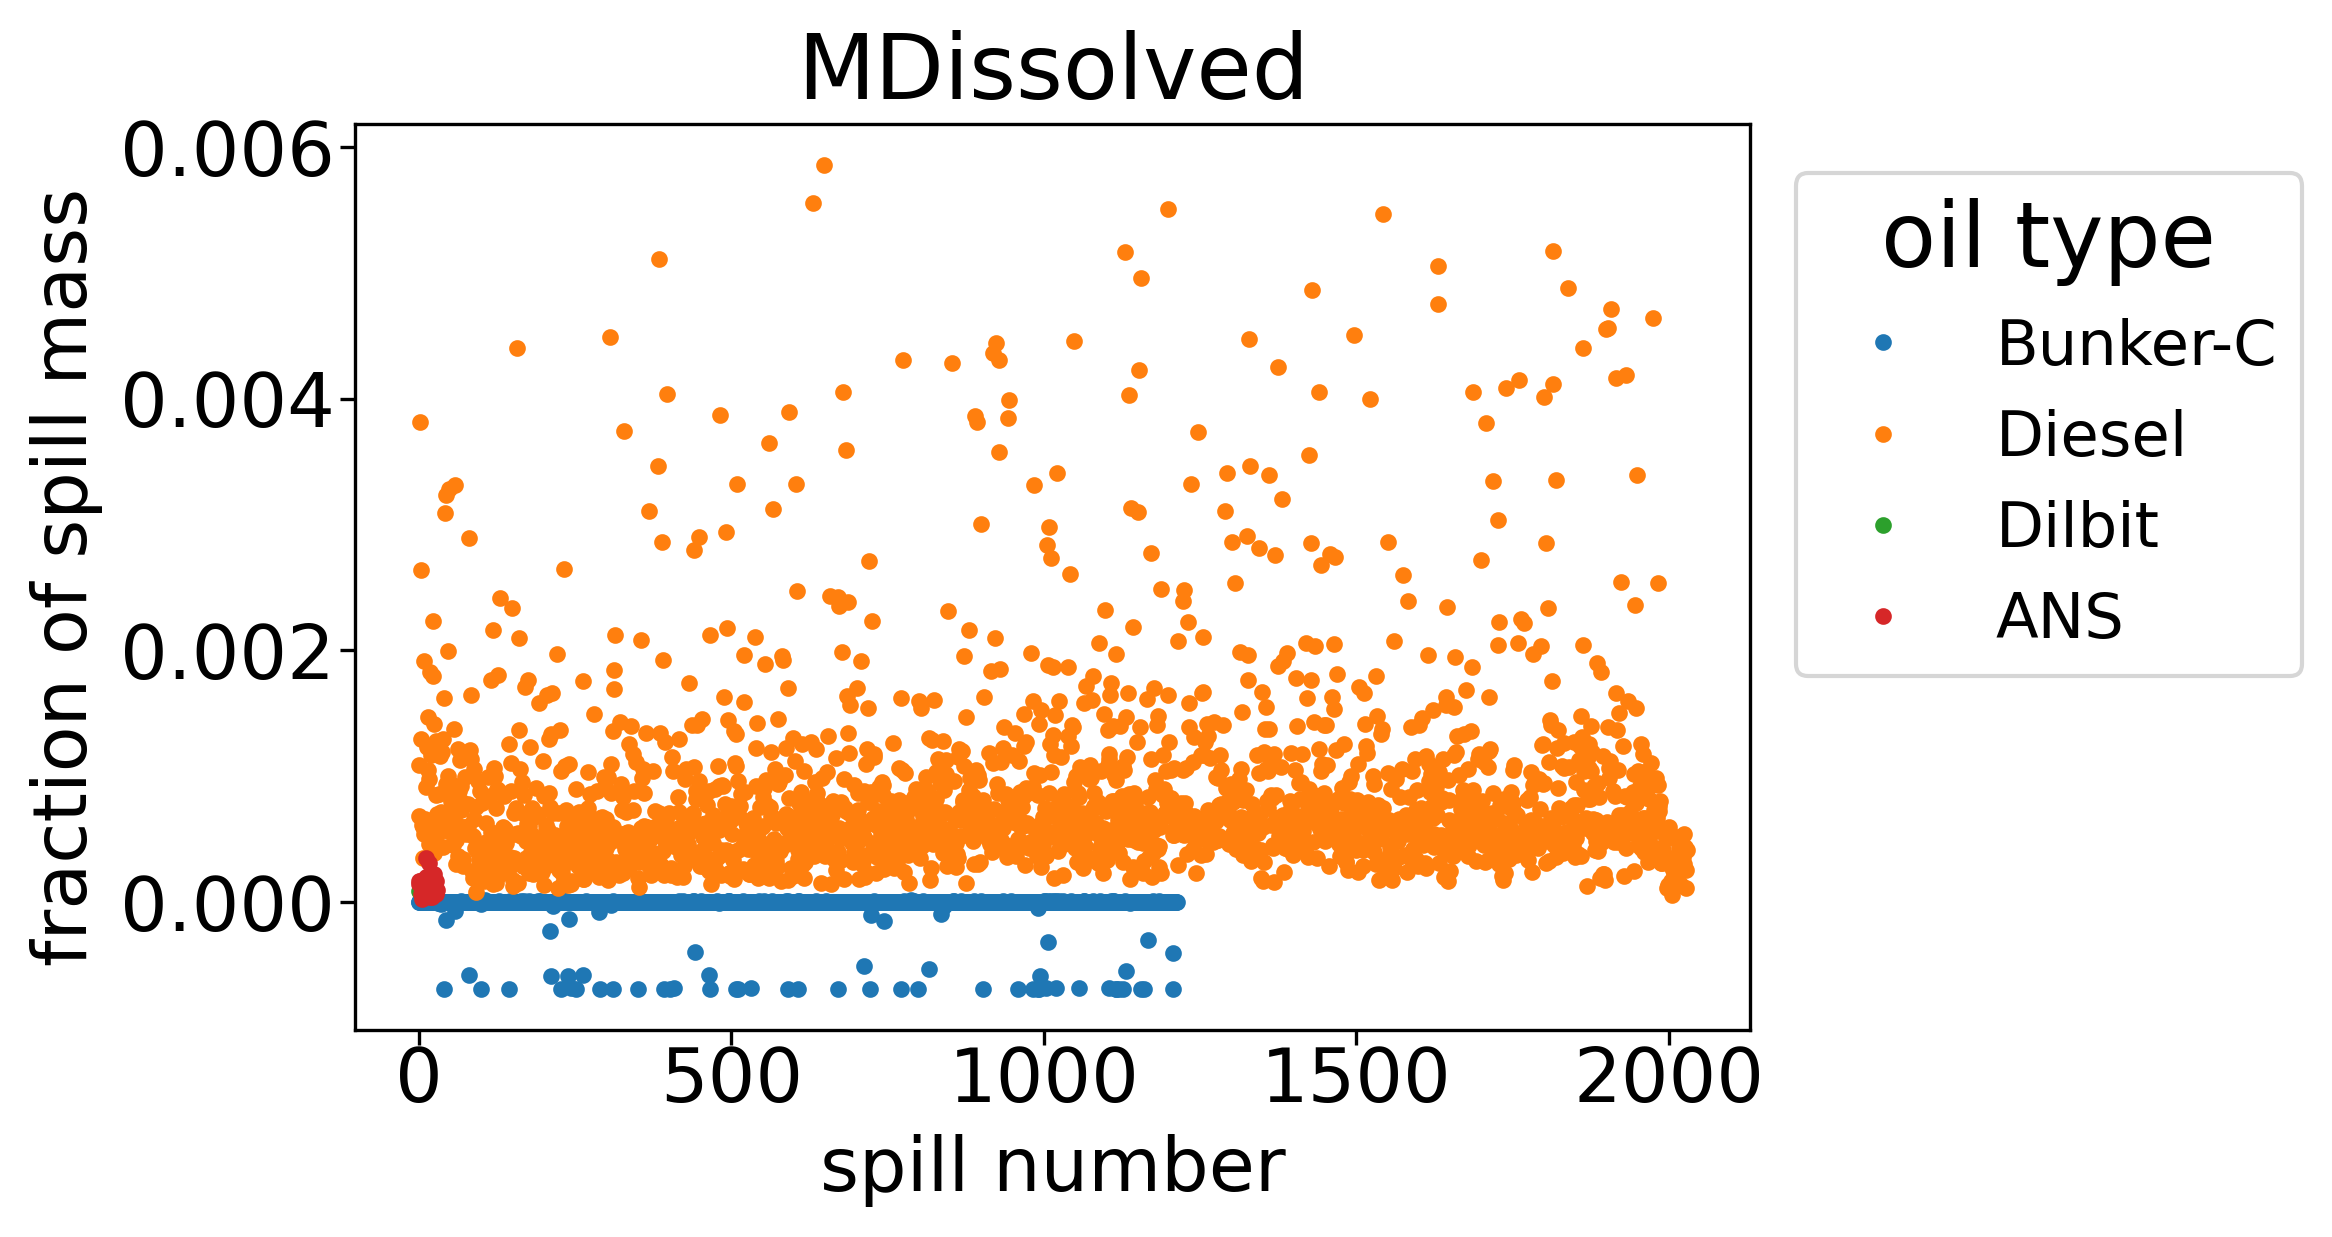

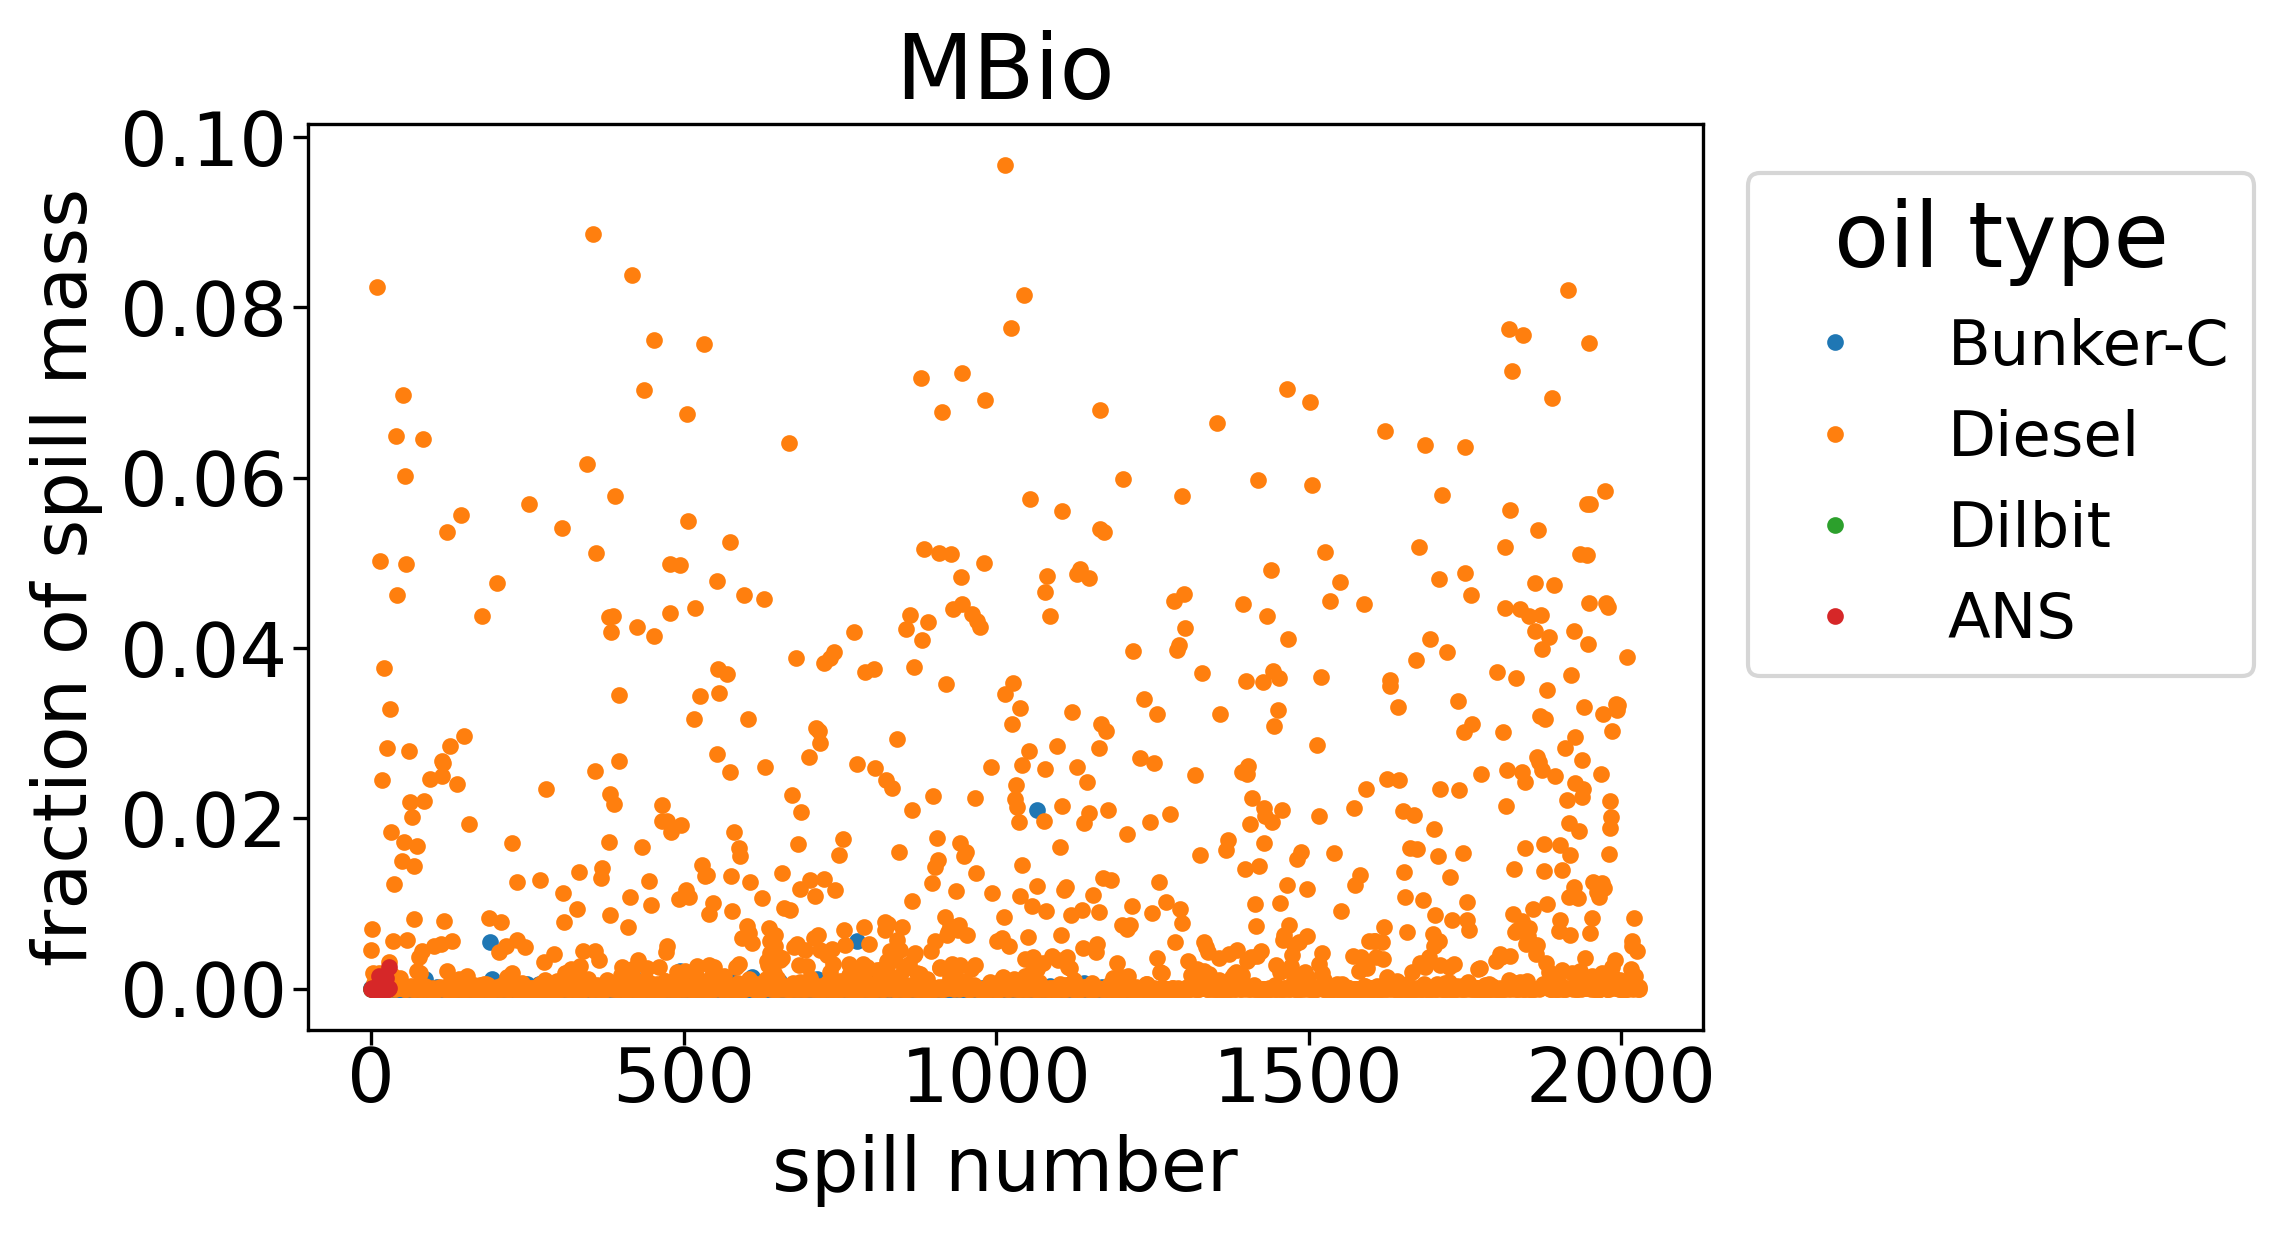

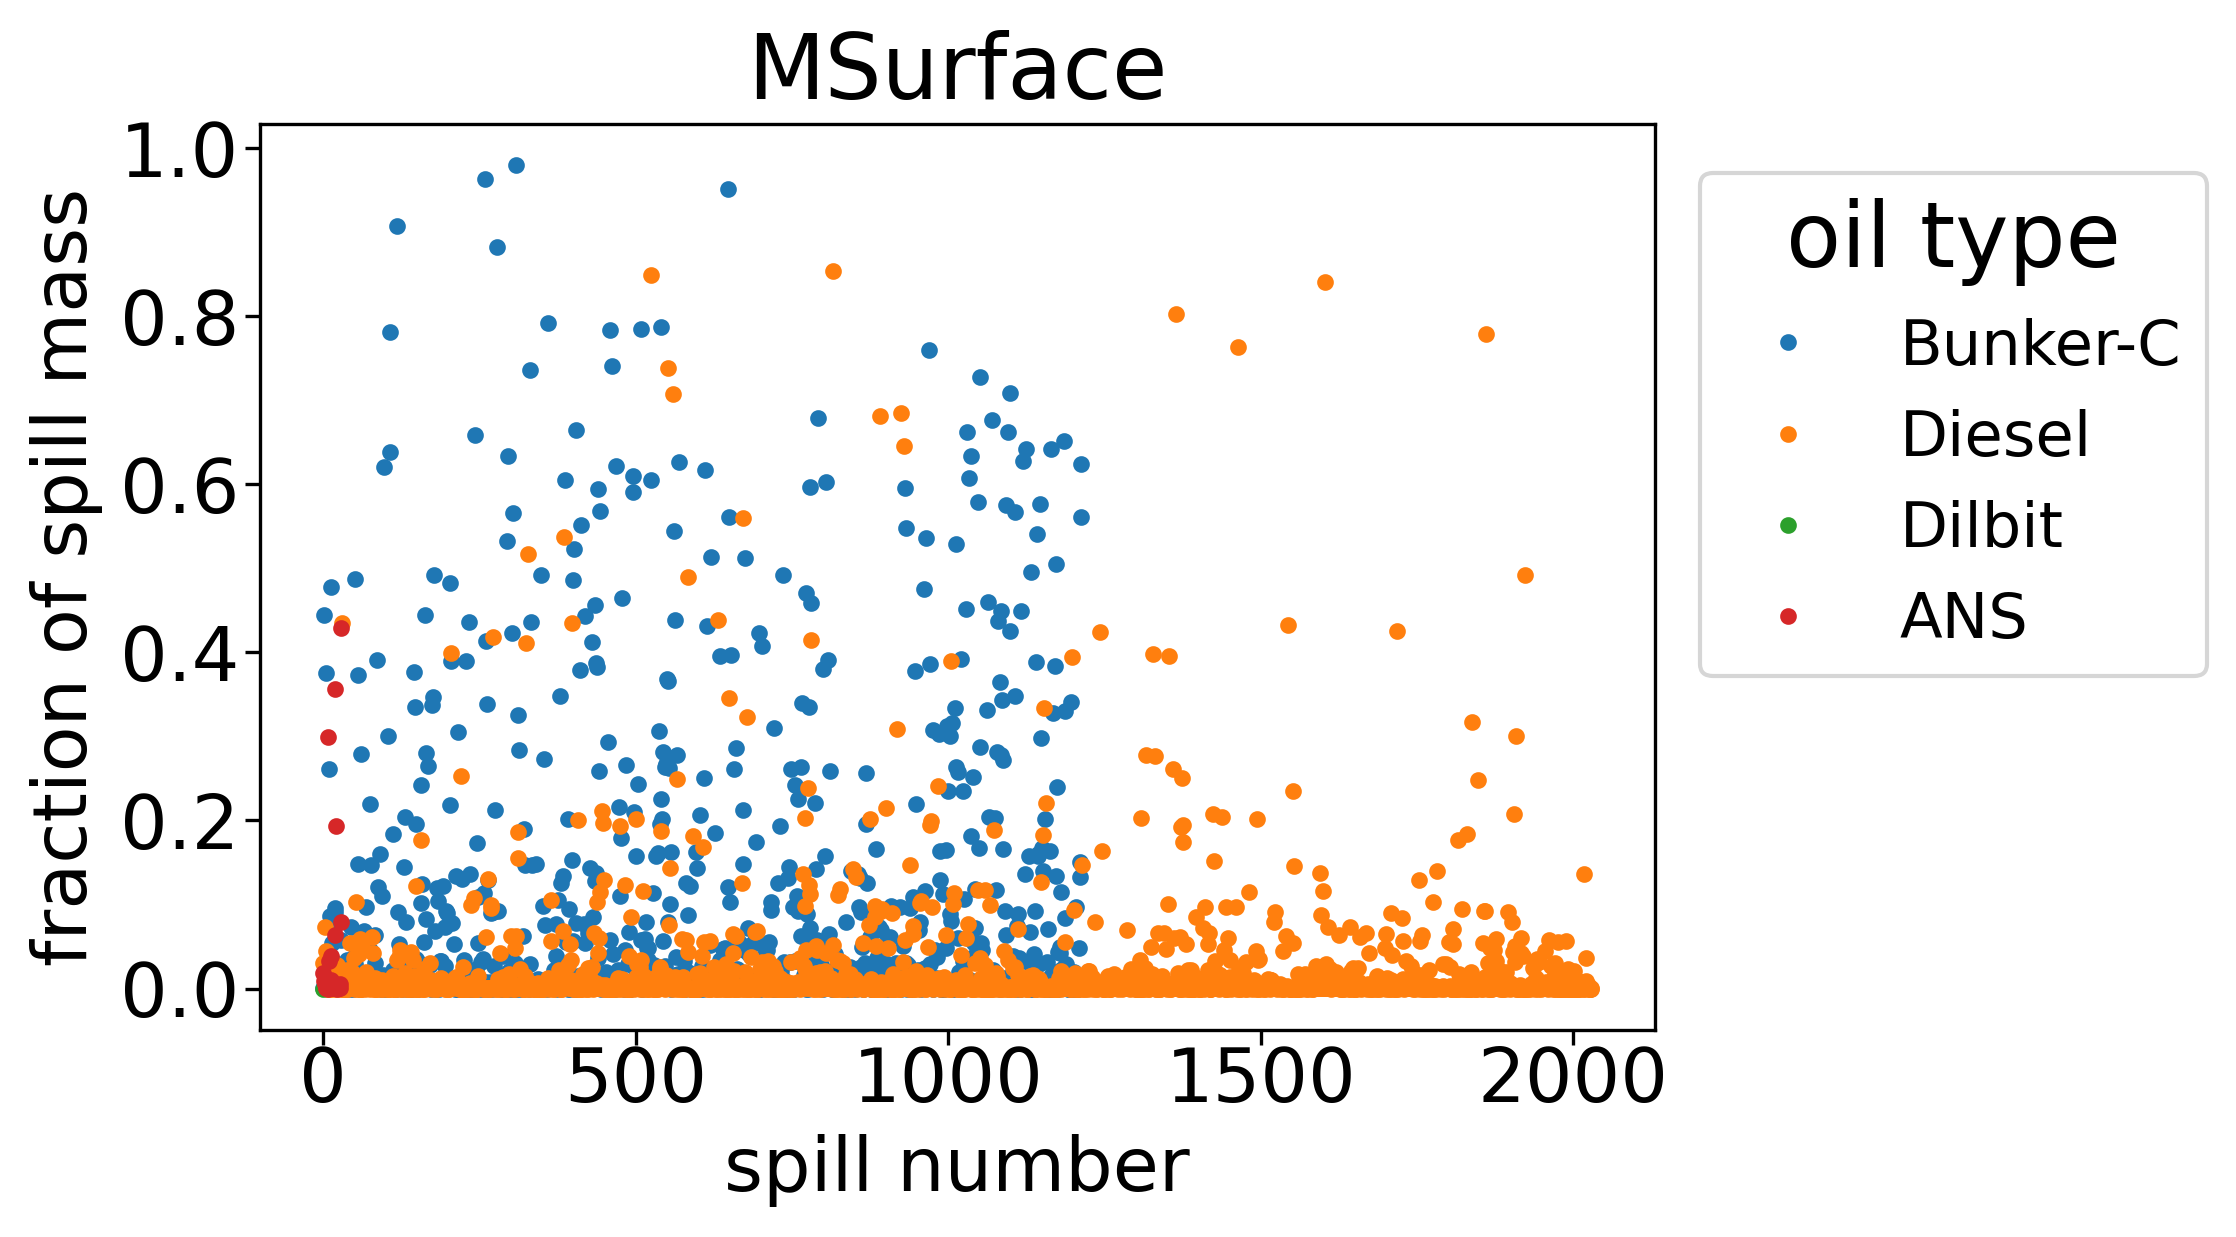

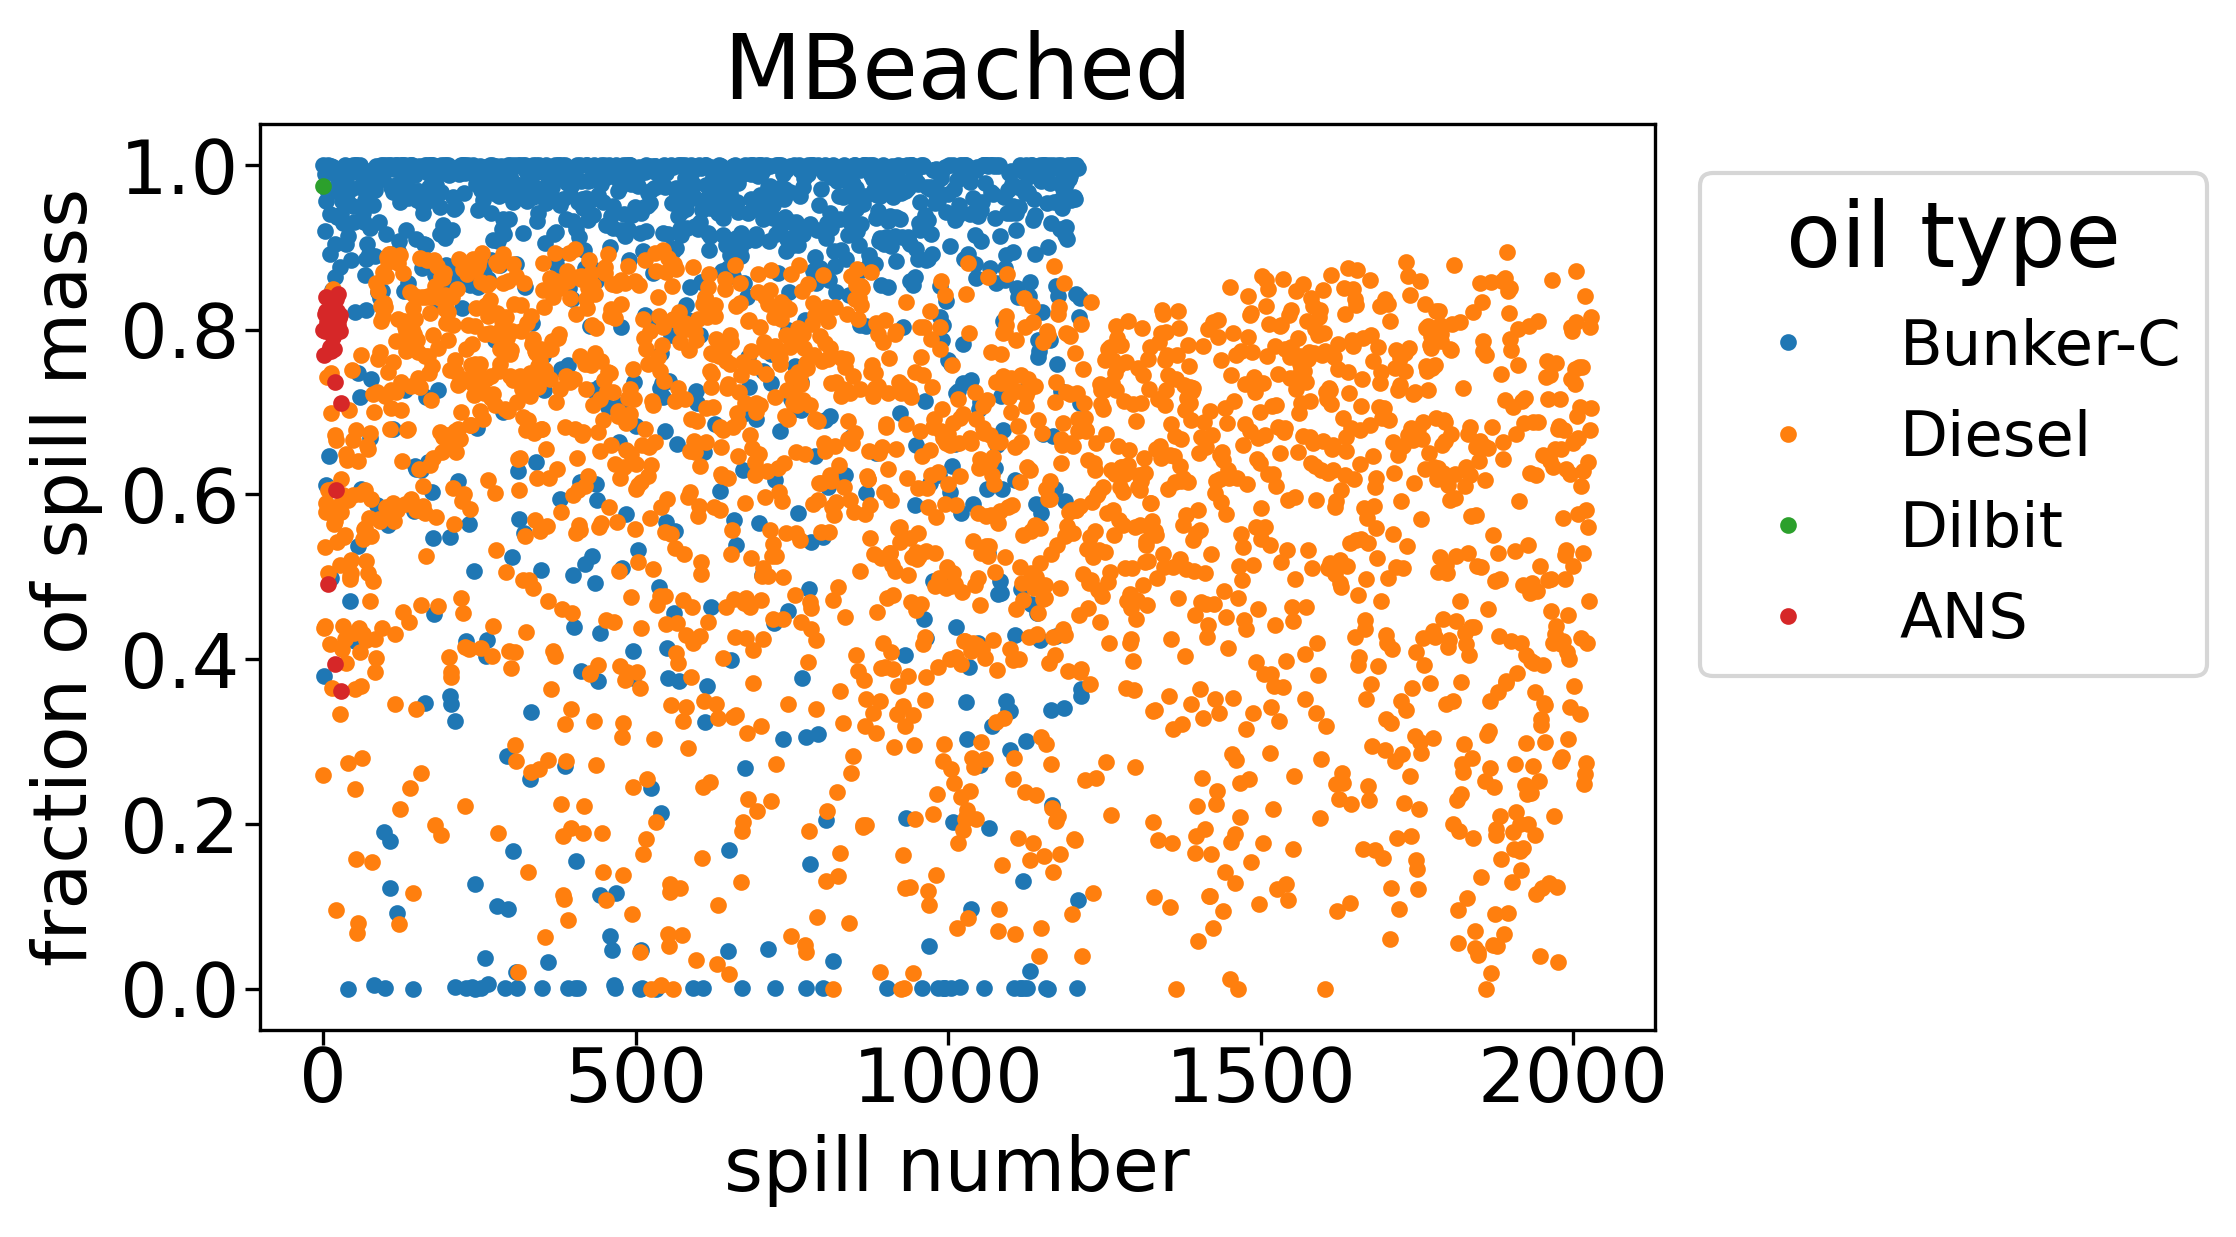

In [11]:
mass_elements = ['MEvaporated', 'MDispersed','MDissolved', 'MBio', 'MSurface', 'MBeached']

for element in mass_elements:
    fig, ax = plt.subplots()
    for oil in oils:
        ax.plot(spill_fraction[element][oil],'.',label=oil)
        ax.set_ylabel('fraction of spill mass')
        ax.set_xlabel('spill number')
    plt.title(element)
    ax.legend(title='oil type', bbox_to_anchor=(1.01, 0.98), loc='upper left')

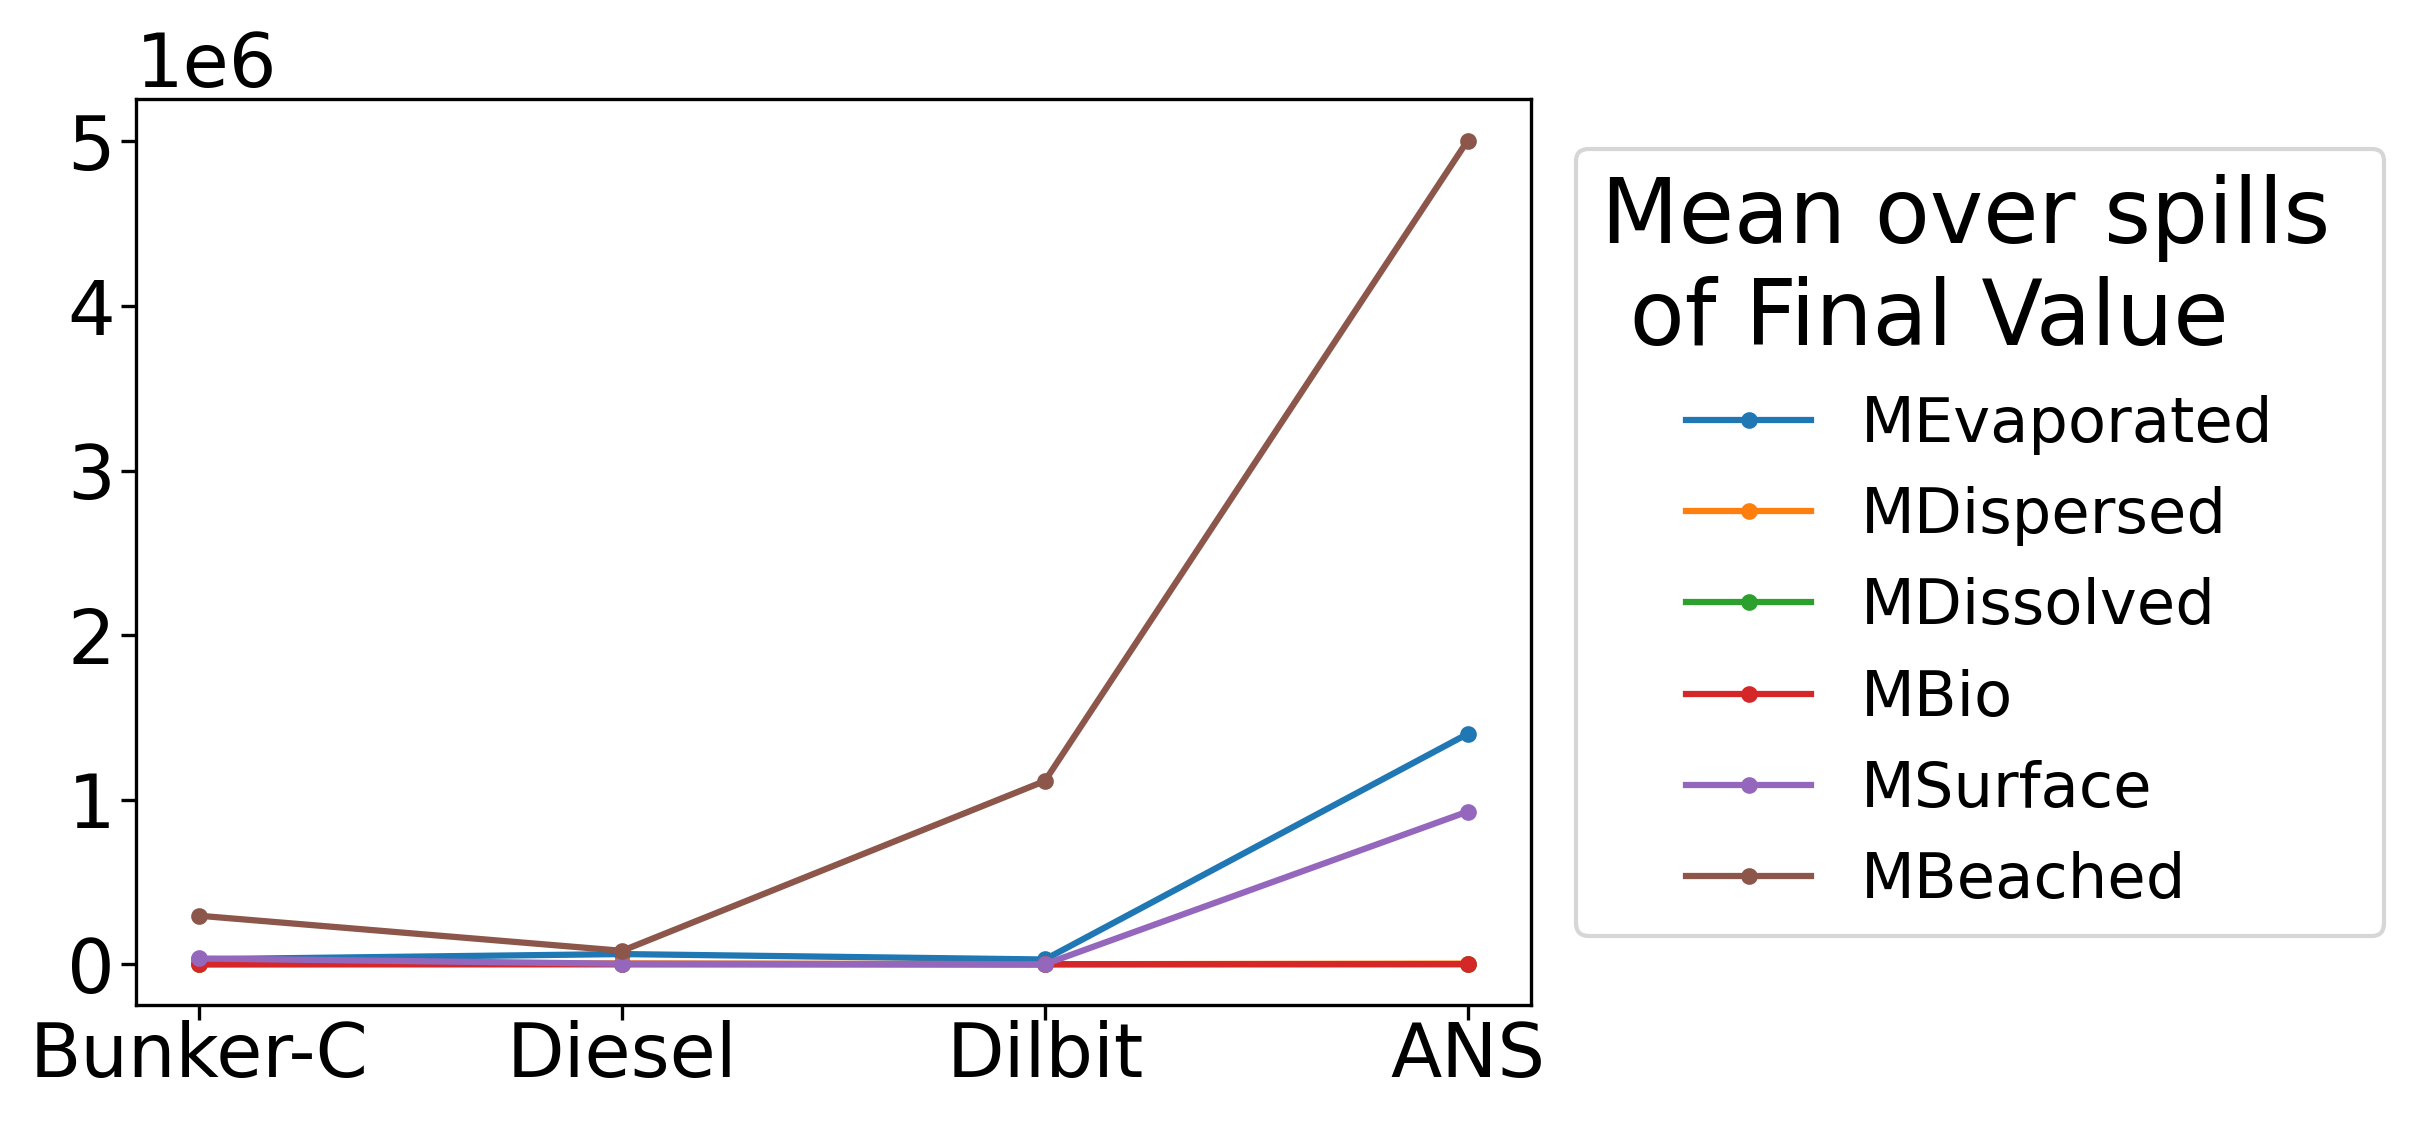

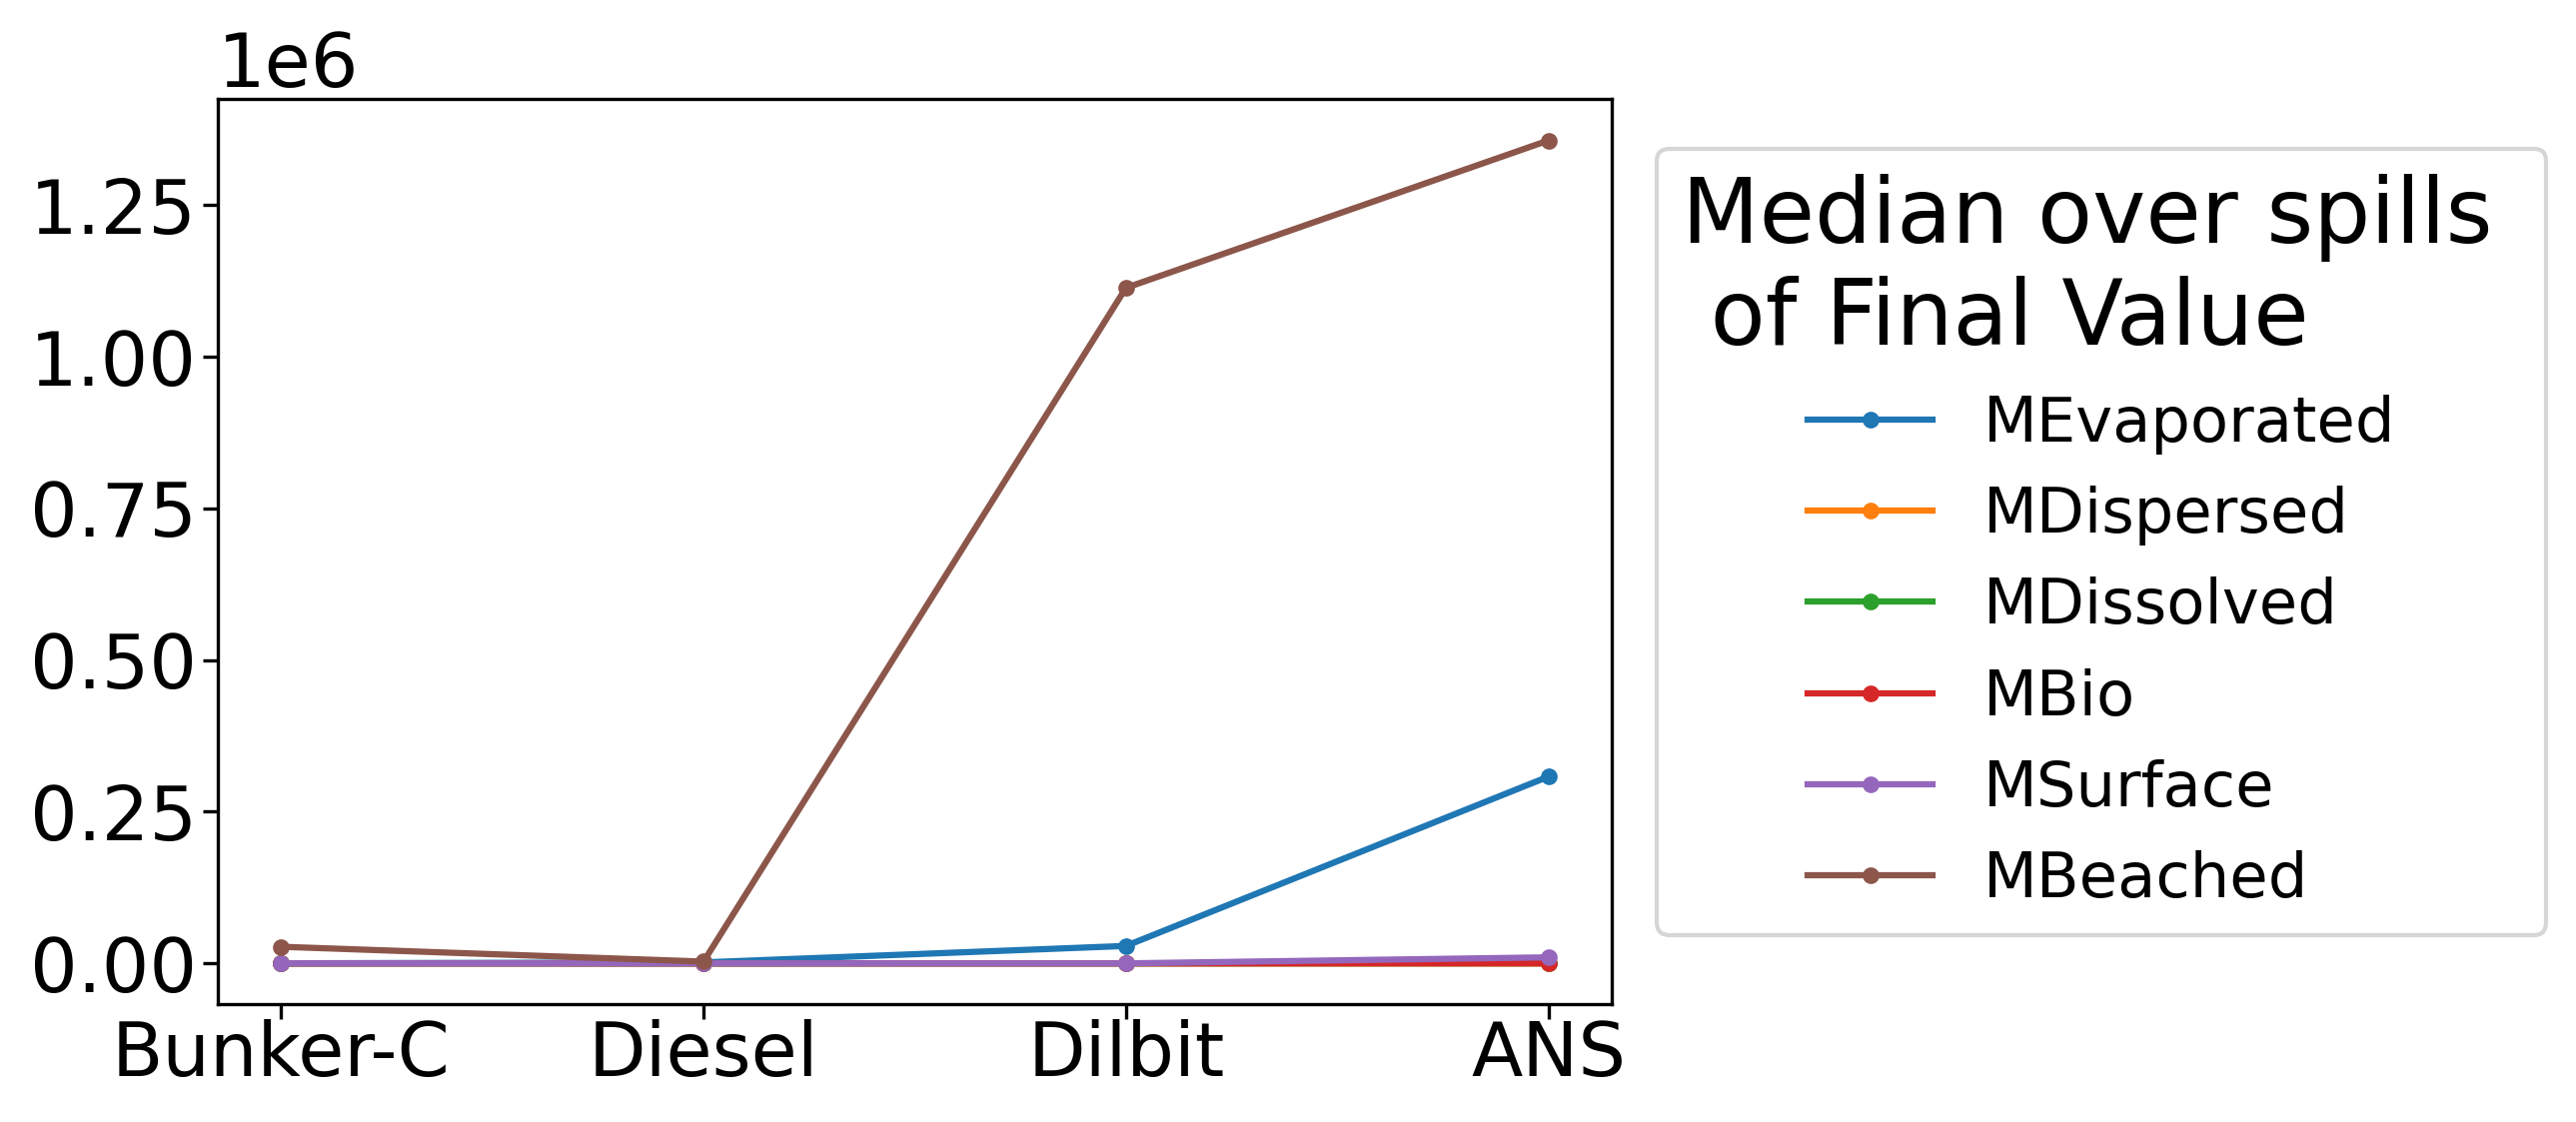

In [12]:
mass_elements = ['MEvaporated', 'MDispersed','MDissolved', 'MBio', 'MSurface', 'MBeached']
fig, ax = plt.subplots()
for element in mass_elements:
    ax.plot(mean[element],'.-',label=element)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(oils)
    #plt.yscale('log')
ax.legend(title='Mean over spills \n of Final Value', bbox_to_anchor=(1.01, 0.98), loc='upper left')
fig, ax = plt.subplots()
for element in mass_elements:
    ax.plot(median[element],'.-',label=element)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(oils)
ax.legend(title='Median over spills \n of Final Value', bbox_to_anchor=(1.01, 0.98), loc='upper left')